# **GraphSAGE** 
Made for the task of Node Regression (node attribute prediction).  
([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216))

## Installation

In [ ]:
#LINUX
!pip install torch==2.4.0
torch_version = str(torch.__version__)
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
!pip install torch-scatter -f $scatter_src
!pip install torch-sparse -f $sparse_src
!pip install torch-geometric

In [ ]:
# run these commands in py-venv if on WINDOWS
"""
pip install pandas
pip install matplotlib
"""

# CPU:
"""
pip install torch==2.4.0
pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.4.0.html
pip install torch-geometric
"""

# GPU:
"""
pip install torch==2.8.0+cu126 --index-url https://download.pytorch.org/whl/cu126
pip install torch-scatter -f https://data.pyg.org/whl/torch-2.8.0+cu126.html
pip install torch_geometric -f https://data.pyg.org/whl/torch-2.8.0+cu126.html
"""

In [4]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())


2.8.0+cu126
12.6
True


## GNN Stack Module

Below is the implementation of a general GNN stack, where we can plugin any GNN layer, such as **GraphSage**, **GAT**...

In [5]:
import os
import torch
import torch_geometric

In [53]:
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType, OptTensor)

from torch.nn import Parameter, Linear
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        # input_dim = length of the node embedding vector
        # hidden_dim = hidden layer (64 - 256)
        # output_dim = prediction 2 dim (posek_iglavcev and posek_listavcev)

        super(GNNStack, self).__init__()
        #builds the layers
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim)) # 1st layer

        # hidden layers are added
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))

        # post-message-passing to final layer: hidden_dim -> output_dim 
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout # probability 0-1
        self.num_layers = args.num_layers
        self.emb = emb # prediction as embedding T/F

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # data.x = node attributes [N, input_dim]
        # data.edge_index = graph edges [2, num_edges] ([senders][recievers])
        # data.batch = which node belongs to which graph (for mini-batching)

        # passes embeddings through the layers
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # return embedding instead
        if self.emb:
            return x

        x = self.post_mp(x) # final predicted output
        x = F.softplus(x)
        return x

    def loss(self, pred, label):
        # small mistake = small loss, big mistake =  big loss
        return F.l1_loss(pred, label)

## GraphSAGE Implementation

In [20]:
class GraphSage(MessagePassing):

    def __init__(self, in_channels, out_channels, normalize = True, bias = False, **kwargs):

        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = torch.nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = torch.nn.Linear(in_channels, out_channels, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):

        # Computes aggregated neighbor embeddings for 
        # each node and adds self-node contribution
        out = self.propagate(edge_index, x=(x,x))
        out = self.lin_l(x) + self.lin_r(out)
        if self.normalize: # optional normalization
          out = torch.nn.functional.normalize(out)

        return out

    # node attributes are sent to neighbors
    def message(self, x_j):
        out = x_j
        return out

    # mean aggregation of GraphSAGE
    def aggregate(self, inputs, index, dim_size = None):
        # inputs = messages(attributes) from neighbors
        # index = target node

        node_dim = self.node_dim # the axis along which to index number of nodes
        out = torch_scatter.scatter(inputs,index,node_dim,reduce="mean")

        return out


## Attribute Encoders

We use the CategoricalEncoder to put each categorical attribute through an MLP and create their embeddings. We concatenate them together with numerical attributes in the AttributeEncoder. Numerical attributes are passed as is.

In [8]:
# a good thing to add would be custom embedding dimension for each attribute
class CategoricalEncoder(nn.Module):
    def __init__(self, size, emb_dim):
        # size = list of all category sizes
        super().__init__()

        # MLP
        self.embedders = nn.ModuleList([
            nn.Sequential(
                nn.Linear(i, emb_dim), 
                nn.ReLU(), 
                nn.Linear(emb_dim,emb_dim))
            for i in size])

    # pushes categorical attributes as one-hot encodings through an MLP    
    def forward(self, id_list, n_classes):
        emb_out = []
        for mlp, ids, categories in zip(self.embedders, id_list, n_classes):
            one_hot = F.one_hot(ids, num_classes=categories).float()
            emb = mlp(one_hot) # <-- [num_nodes, emb_dim]
            emb_out.append(emb)

        # concatenates them all together
        return torch.cat(emb_out, dim=1)
        
class AttributeEncoder(nn.Module):
    def __init__(self, val_cols, size, emb_dim, out_emb_dim):
        # val_cols = number of numeric attributes
        # size = list of categorical attributes
        super().__init__()

        self.category_encoder = CategoricalEncoder(size, emb_dim)
        total_dim = len(size) * emb_dim

        self.mlp = nn.Sequential(
            nn.Linear(val_cols + total_dim, out_emb_dim),
            nn.ReLU(),
            nn.Linear(out_emb_dim, out_emb_dim)
        )

    def forward(self, val_attr, cat_attr, n_classes):
        cat_emb = self.category_encoder(cat_attr, n_classes)
        x = torch.cat([val_attr, cat_emb], dim=1)
        return self.mlp(x)

## DB Conversion

We convert the DB to actual usable data, like nodes, attributes, edges...

In [13]:
import pandas as pd
import sqlite3 as sql
from torch_geometric.data import Data

db_directory = "../../datasets/forest_db.sqlite" # <<<--- CHANGE THIS TO THE DATASET YOU ARE USING!!!

# extracts relevant data from DB
db = sql.connect(db_directory)
nodes = pd.read_sql_query("SELECT id FROM nodes", db)
node_attr = pd.read_sql_query("SELECT * FROM sestoji_attr", db)
edges = pd.read_sql_query("SELECT n1_id, n2_id FROM edges", db)

# create a mapping from global node IDs to 0-based indices
node_ids = nodes['id'].tolist()  # current subset
id_to_idx = {nid: i for i, nid in enumerate(node_ids)}

# filter edges to only those where both nodes are in the subset
edges = edges[edges['n1_id'].isin(id_to_idx) & edges['n2_id'].isin(id_to_idx)].copy()
edges['n1_id'] = edges['n1_id'].map(id_to_idx)
edges['n2_id'] = edges['n2_id'].map(id_to_idx)
edge_index = torch.tensor(edges[['n1_id', 'n2_id']].values, dtype=torch.long).t().contiguous()

print(edge_index.shape)  # [2, num_edges]
print(edge_index.min(), edge_index.max())  # should be in [0, num_nodes-1]

# attributes with numeric values (we need to add tree composition)
val_cols = ['povrsina', 'pompov', 'pomzas', 
    'lzigl', 'lzlst']
value_attr = torch.tensor(node_attr[val_cols].values, dtype=torch.float)

# categorical string attributes
cat_cols = ['rfaza', 'sksmerni', 'zasnova', 'sklep', 'negovan', 'pomzas']
for col in ['zasnova', 'sklep', 'negovan']: # idk why, but some are still strings?
    node_attr[col] = node_attr[col].astype(int) 
categorical_attr = [torch.tensor(node_attr[i].values, dtype=torch.long) for i in cat_cols]

# prediction attributes
trg_cols = ['etigl', 'etlst']
target_attr = torch.tensor(node_attr[trg_cols].values, dtype=torch.float)

data = Data(x=None, numeric=value_attr, edge_index=edge_index, y=target_attr)
data.rfaza = categorical_attr[0]
data.sksmerni = categorical_attr[1]
data.zasnova = categorical_attr[2]
data.sklep = categorical_attr[3]
data.negovan = categorical_attr[4]
data.pomzas = categorical_attr[5]

categories = [11,21,5,6,5,5] # number of categories are determined by the data provided from the DB
numeric_attr = len(val_cols)
# encode all attributes
encoder = AttributeEncoder(numeric_attr,categories,emb_dim=2,out_emb_dim=16)

cat_list = [data.rfaza, data.sksmerni, data.zasnova, data.sklep, data.negovan, data.pomzas]
data.x = encoder(data.numeric, cat_list, categories)
print(data)



torch.Size([2, 1877718])
tensor(0) tensor(347337)
Data(edge_index=[2, 1877718], y=[347338, 2], numeric=[347338, 5], rfaza=[347338], sksmerni=[347338], zasnova=[347338], sklep=[347338], negovan=[347338], pomzas=[347338], x=[347338, 16])


## Optimizers

In [14]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

## Let's Start the Training!

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Epoch 000 | Train MAE: 103.03 (99.76%) | Val MAE: 102.37 (99.56%)
Epoch 001 | Train MAE: 102.83 (99.56%) | Val MAE: 101.83 (99.03%)
Epoch 002 | Train MAE: 102.29 (99.04%) | Val MAE: 101.06 (98.28%)
Epoch 003 | Train MAE: 101.53 (98.31%) | Val MAE: 100.33 (97.57%)
Epoch 004 | Train MAE: 100.80 (97.60%) | Val MAE: 99.95 (97.20%)
Epoch 005 | Train MAE: 100.44 (97.25%) | Val MAE: 99.24 (96.52%)
Epoch 006 | Train MAE: 99.74 (96.57%) | Val MAE: 98.21 (95.51%)
Epoch 007 | Train MAE: 98.72 (95.59%) | Val MAE: 96.65 (93.99%)
Epoch 008 | Train MAE: 97.16 (94.08%) | Val MAE: 95.36 (92.74%)
Epoch 009 | Train MAE: 95.88 (92.84%) | Val MAE: 94.44 (91.84%)
Epoch 010 | Train MAE: 94.94 (91.92%) | Val MAE: 93.62 (91.04%)
Epoch 011 | Train MAE: 94.09 (91.10%) | Val MAE: 92.75 (90.20%)
Epoch 012 | Train MAE: 93.23 (90.27%) | Val MAE: 93.03 (90.47%)
Epoch 013 | Train MAE: 93.46 (90.50%) | Val MAE: 91.89 (89.37%)
Epoch 014 | Train MAE: 92.28 (89.35%) | Val MAE: 90.62 (88.13%)
Epoch 015 | Train MAE: 90.99 (

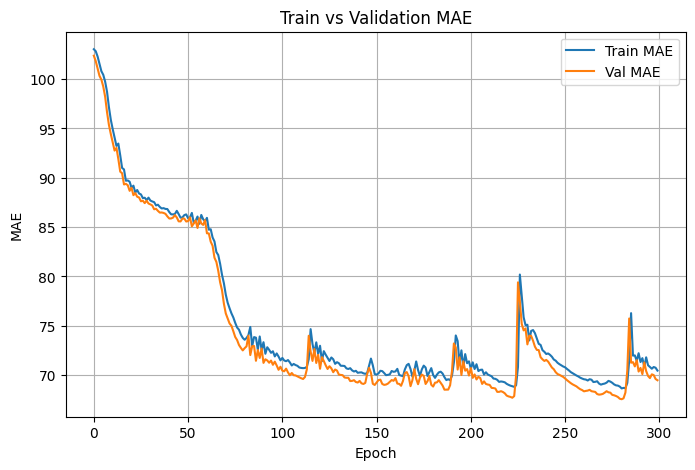

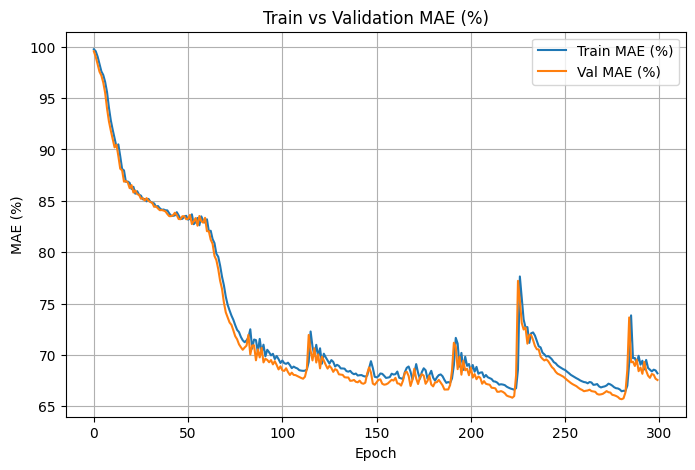

In [55]:
import torch
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt

data = data.to(device)
data.x = data.x.detach()

# Train/val/test per node split
num_nodes = data.num_nodes
perm = torch.randperm(num_nodes)
train_idx = perm[:int(0.8*num_nodes)]
val_idx   = perm[int(0.8*num_nodes):int(0.9*num_nodes)]
test_idx  = perm[int(0.9*num_nodes):]

class Args:
    model_type = 'GraphSage'
    num_layers = 2 # k-hop neighborhood (k=2 seems to be the best...)
    hidden_dim = 64
    dropout = 0.05
args = Args()

# Model
feature_dim = data.x.size(1)
target_dim  = data.y.size(1)
model = GNNStack(input_dim=feature_dim,
                 hidden_dim=args.hidden_dim,
                 output_dim=target_dim,
                 args=args).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=5e-3)

mean_train_targets = data.y[train_idx].mean().item()
mean_val_targets = data.y[val_idx].mean().item()
mean_test_targets = data.y[test_idx].mean().item()

# Tracking
train_losses = []
val_losses   = []
train_pct_errors = []
val_pct_errors   = []

best_val_loss = float('inf')
best_model = None
epochs = 300

for epoch in range(epochs):

    # Training
    model.train()
    optimizer.zero_grad()

    out = model(data)
    train_loss = model.loss(out[train_idx], data.y[train_idx])
    train_loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_out = model(data)
        val_loss = model.loss(val_out[val_idx], data.y[val_idx])

    # Track losses
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    # Percentage errors
    train_pct_errors.append((train_loss.item() / mean_train_targets) * 100)
    val_pct_errors.append((val_loss.item() / mean_val_targets) * 100)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

    if epoch % 1 == 0:
        print(
            f"Epoch {epoch:03d} | "
            f"Train MAE: {train_loss.item():.2f} ({train_pct_errors[-1]:.2f}%) | "
            f"Val MAE: {val_loss.item():.2f} ({val_pct_errors[-1]:.2f}%)"
        )

# Test
best_model.eval()
with torch.no_grad():
    test_out = best_model(data)
    test_mae = model.loss(test_out[test_idx], data.y[test_idx])
    test_pct_error = (test_mae.item() / mean_test_targets) * 100
    print(f"\nTest MAE: {test_mae.item():.2f} ({test_pct_error:.2f}%)")

# ===========================
#        PLOTTING
# ===========================

# Plot absolute MAE
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train MAE')
plt.plot(val_losses,   label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Train vs Validation MAE')
plt.legend()
plt.grid(True)
plt.show()

# Plot percentage MAE
plt.figure(figsize=(8,5))
plt.plot(train_pct_errors, label='Train MAE (%)')
plt.plot(val_pct_errors,   label='Val MAE (%)')
plt.xlabel('Epoch')
plt.ylabel('MAE (%)')
plt.title('Train vs Validation MAE (%)')
plt.legend()
plt.grid(True)
plt.show()


In [52]:
import numpy as np

# Set the model to evaluation mode
best_model.eval()

# Make predictions on the entire dataset
with torch.no_grad():
    all_predictions = best_model(data)

# Convert predictions and true labels to numpy for easier handling
predictions_np = all_predictions.cpu().numpy()
true_labels_np = data.y.cpu().numpy()
attributes = data.numeric.cpu().numpy()

# Get a few random indices from the test set
num_samples_to_show = 50
random_test_indices = np.random.choice(test_idx.cpu().numpy(), num_samples_to_show, replace=False)

print(f"Displaying predictions for {num_samples_to_show} random nodes from the test set:\n")

for i, idx in enumerate(random_test_indices):
    current_zaloga_igl = attributes[idx, val_cols.index('lzigl')]
    current_zaloga_lst = attributes[idx, val_cols.index('lzlst')]
    true_etigl = true_labels_np[idx, 0]
    true_etlst = true_labels_np[idx, 1]
    pred_etigl = round(predictions_np[idx, 0])
    pred_etlst = round(predictions_np[idx, 1])

    print(f"Node {idx + 1} (Test Sample {i + 1}):")
    print(f"  Current zaloga igl: {current_zaloga_igl:.2f}")
    print(f"  True etigl: {true_etigl:.2f}, Predicted etigl: {pred_etigl:.2f}, Diff: {abs(true_etigl - pred_etigl):.2f}")
    print(f"  Current zaloga lst: {current_zaloga_lst:.2f}")
    print(f"  True etlst: {true_etlst:.2f}, Predicted etlst: {pred_etlst:.2f}, Diff: {abs(true_etlst - pred_etlst):.2f}")
    print("--------------------------------------------------")


Displaying predictions for 50 random nodes from the test set:

Node 126626 (Test Sample 1):
  Current zaloga igl: 13.00
  True etigl: 4.00, Predicted etigl: 7.00, Diff: 3.00
  Current zaloga lst: 465.00
  True etlst: 129.00, Predicted etlst: 49.00, Diff: 80.00
--------------------------------------------------
Node 112223 (Test Sample 2):
  Current zaloga igl: 0.00
  True etigl: 0.00, Predicted etigl: 0.00, Diff: 0.00
  Current zaloga lst: 163.00
  True etlst: 21.00, Predicted etlst: 43.00, Diff: 22.00
--------------------------------------------------
Node 15603 (Test Sample 3):
  Current zaloga igl: 302.00
  True etigl: 91.00, Predicted etigl: 0.00, Diff: 91.00
  Current zaloga lst: 83.00
  True etlst: 17.00, Predicted etlst: 27.00, Diff: 10.00
--------------------------------------------------
Node 189524 (Test Sample 4):
  Current zaloga igl: 0.00
  True etigl: 0.00, Predicted etigl: 0.00, Diff: 0.00
  Current zaloga lst: 361.00
  True etlst: 43.00, Predicted etlst: 119.00, Diff: 7